In [2]:
from survae.data import *
from survae.layer import *
from survae.plot import *
from survae.train import *

In [3]:
middle_abs_model_generators = [
    lambda: SurVAE(
        [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(5)
        ] + [
            AbsoluteUnit(torch.tensor([1 / 2, 1 / 2])),
        ] + [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(5)
        ],
        name="NF-middle-abs",
    ),
    lambda: SurVAE(
        [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(5)
        ] + [
            AbsoluteUnit(torch.tensor([1 / 2, 1 / 2]), learn_q=True),
        ] + [
            [BijectiveLayer(2, [64] * 5), OrthonormalLayer(2)]
            for _ in range(5)
        ],
        name="NF-middle-abs-learned_q",
    )
]

In [4]:
datasets = [Ngon(), Circles(), Corners(), Checkerboard()]

In [5]:
models = train_models(middle_abs_model_generators, datasets, epochs=100)

100%|██████████| 8/8 [01:30<00:00, 11.34s/it]


In [32]:
n_models = len(models)
n_cols = 2  # set manually
n_rows = n_models // n_cols

axis_len = 10  # sample length for axis visualization
axis_n_samples = 10_000  # number of samples per axis
distr_n_samples = 10_000  # number of samples for distribution

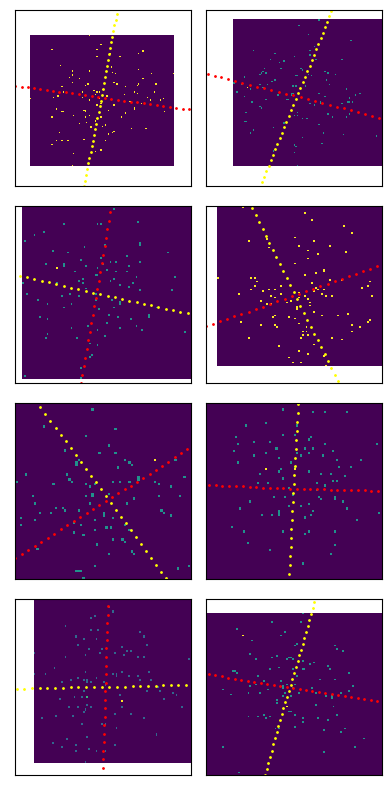

In [36]:
keys = models.keys()

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

for key in keys:
    model = models[key][0]
    i,j = key

    
    with torch.no_grad():
        samples = model.sample(distr_n_samples).cpu().numpy()

        _axis = torch.linspace(-axis_len, axis_len, axis_n_samples)
        _zeros = torch.zeros(axis_n_samples)

        x_axis = torch.stack((_axis, _zeros), dim=1)
        y_axis = torch.stack((_zeros, _axis), dim=1)

        for layer in reversed(model.layers[:9]):
            x_axis = layer.backward(x_axis)
            y_axis = layer.backward(y_axis)

    x_axis = x_axis.cpu()
    y_axis = y_axis.cpu()
    
    _ax = ax[i,j]

    _ax.hist2d(samples[:, 0], samples[:, 1], bins=100)
    _ax.scatter(x_axis[:, 0], x_axis[:, 1], s=1, c="red")
    _ax.scatter(y_axis[:, 0], y_axis[:, 1], s=1, c="yellow")

    _ax.set_xlim(-2.5, 2.5)
    _ax.set_ylim(-2.5, 2.5)
    _ax.set_aspect("equal")

    _ax.set_xticks([])
    _ax.set_yticks([])
plt.tight_layout()
plt.show()